## Load MNIST and Normalize

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import StandardScaler

# Load MNIST
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
X, y = mnist.data[:1000], mnist.target.astype(int)[:1000]  # subsample for speed

# Normalize
X = StandardScaler().fit_transform(X)

## Construct Adjacency Matrix for 28x28 Pixels

In [7]:
def pixel_adjacency_matrix(img_shape=(28, 28)):
    h, w = img_shape
    n = h * w
    A = np.zeros((n, n))

    def pixel_index(x, y):
        return x * w + y

    for i in range(h):
        for j in range(w):
            idx = pixel_index(i, j)
            for dx, dy in [(-1,0),(1,0),(0,-1),(0,1),(-1,-1),(1,1),(-1,1),(1,-1)]:
                ni, nj = i + dx, j + dy
                if 0 <= ni < h and 0 <= nj < w:
                    nidx = pixel_index(ni, nj)
                    A[idx, nidx] = 1
    return A

A = pixel_adjacency_matrix()


## Compute Graph Laplacian L=D−A

In [8]:
def compute_graph_laplacian(A):
    D = np.diag(np.sum(A, axis=1))
    L = D - A
    return L

L = compute_graph_laplacian(A)


## Solve Generalized Eigenvalue Problem

In [11]:
def graph_constrained_pca(X, L, n_components=2, lambda_val=1e-2):
    X_centered = X - np.mean(X, axis=0)  # shape: (n_samples, n_features)
    
    # Standard covariance matrix
    XT_X = np.dot(X_centered.T, X_centered)  # shape: (n_features, n_features)
    
    # Graph constraint term: apply Laplacian in feature space
    XT_L_X = np.dot(X_centered.T, np.dot(X_centered, L))  # also (n_features, n_features)

    # Combined objective matrix
    M = XT_X + lambda_val * XT_L_X

    # Solve eigenvalue problem
    eigenvalues, eigenvectors = np.linalg.eigh(M)
    idx = np.argsort(eigenvalues)[::-1]  # descending order
    W = eigenvectors[:, idx[:n_components]]  # top k eigenvectors

    # Project centered data
    X_gc_pca = np.dot(X_centered, W)
    return X_gc_pca, W


## Run GCPCA and Plot

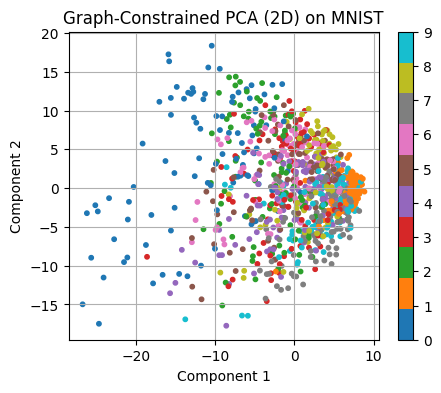

In [15]:
X_gc_pca, W_gc = graph_constrained_pca(X, L, n_components=2, lambda_val=1e-2)

plt.figure(figsize=(5, 4))
plt.scatter(X_gc_pca[:, 0], X_gc_pca[:, 1], c=y, cmap='tab10', s=10)
plt.title("Graph-Constrained PCA (2D) on MNIST")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.grid(True)
plt.colorbar()
plt.show()

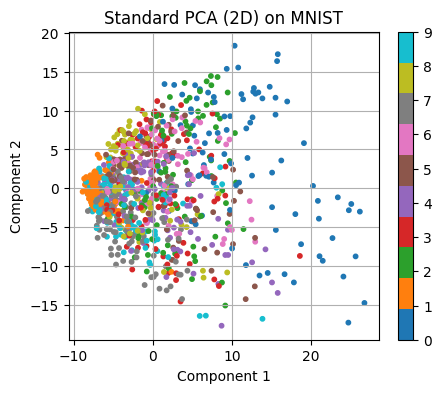

In [16]:
from sklearn.decomposition import PCA

X_pca = PCA(n_components=2).fit_transform(X)

plt.figure(figsize=(5, 4))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='tab10', s=10)
plt.title("Standard PCA (2D) on MNIST")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.grid(True)
plt.colorbar()
plt.show()


In [17]:
from sklearn.metrics import silhouette_score


In [18]:
# For Standard PCA
sil_score_pca = silhouette_score(X_pca, y)
print(f"Silhouette Score (Standard PCA): {sil_score_pca:.4f}")

# For Graph-Constrained PCA
sil_score_gc = silhouette_score(X_gc_pca, y)
print(f"Silhouette Score (Graph-Constrained PCA): {sil_score_gc:.4f}")


Silhouette Score (Standard PCA): -0.0980
Silhouette Score (Graph-Constrained PCA): -0.0987


In [19]:
X_gc_pca_3d, _ = graph_constrained_pca(X, L, n_components=3, lambda_val=1e-2)


In [20]:
from sklearn.decomposition import PCA
X_pca_3d = PCA(n_components=3).fit_transform(X)


In [21]:
from mpl_toolkits.mplot3d import Axes3D

def plot_3d(X, y, title):
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    scatter = ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=y, cmap='tab10', s=10)
    ax.set_title(title)
    ax.set_xlabel('Component 1')
    ax.set_ylabel('Component 2')
    ax.set_zlabel('Component 3')
    plt.colorbar(scatter)
    plt.grid(True)
    plt.show()


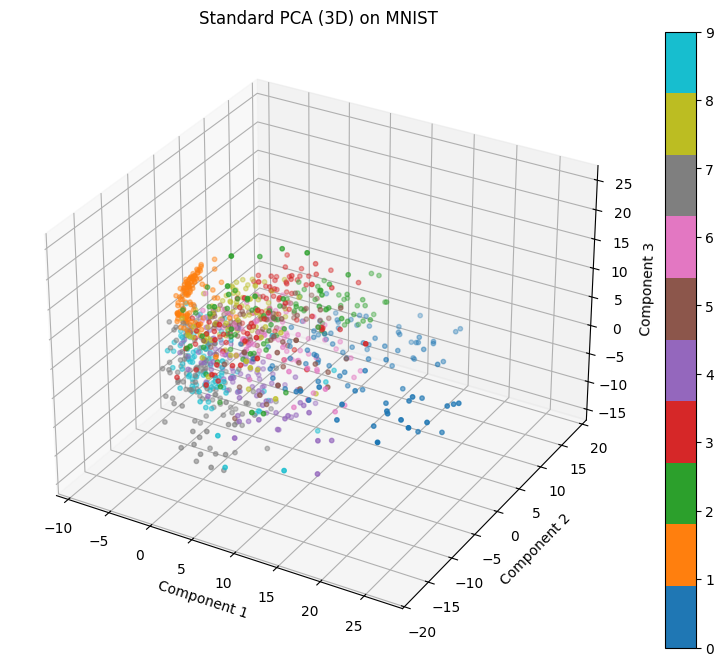

In [22]:
plot_3d(X_pca_3d, y, "Standard PCA (3D) on MNIST")


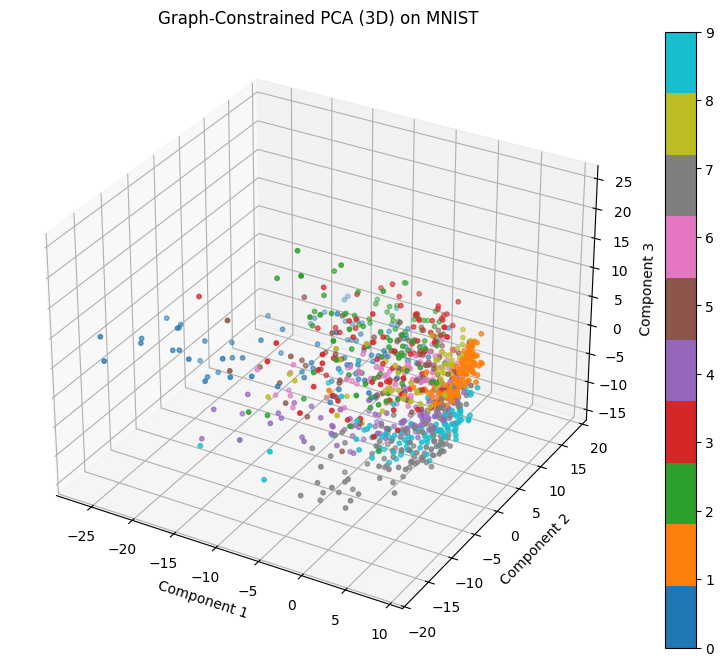

In [23]:
plot_3d(X_gc_pca_3d, y, "Graph-Constrained PCA (3D) on MNIST")


In [24]:
import plotly.express as px
import pandas as pd

def plot_3d_plotly(X, y, title):
    df = pd.DataFrame(X, columns=['Component 1', 'Component 2', 'Component 3'])
    df['Label'] = y

    fig = px.scatter_3d(df, x='Component 1', y='Component 2', z='Component 3',
                        color=df['Label'].astype(str),
                        title=title,
                        color_discrete_sequence=px.colors.qualitative.T10)
    fig.update_traces(marker=dict(size=4))
    fig.show()


In [26]:
# Graph-Constrained PCA (3D)
X_gc_pca_3d, _ = graph_constrained_pca(X, L, n_components=3, lambda_val=1e-2)

# Standard PCA (3D)
from sklearn.decomposition import PCA
X_pca_3d = PCA(n_components=3).fit_transform(X)

In [27]:
plot_3d_plotly(X_gc_pca_3d, y, "Graph-Constrained PCA (3D) on MNIST")
plot_3d_plotly(X_pca_3d, y, "Standard PCA (3D) on MNIST")
